In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 17 12:09:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [ ]:
X_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_trainv7_exp1_exp5_strat.npy")
y_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_trainv7_exp1_exp5_strat.npy").astype(int)

X_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_testv7_exp1_exp5_strat.npy")
y_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_testv7_exp1_exp5_strat.npy").astype(int)


In [ ]:
# X_train=X_train+np.random.choice([-1,1],X_train.shape)
# X_test=X_test+np.random.choice([-1,1],X_test.shape)

In [ ]:
X_train_1d=np.gradient(X_train,axis=1)
X_test_1d=np.gradient(X_test,axis=1)

X_train=np.dstack([X_train,X_train_1d])
X_test=np.dstack([X_test,X_test_1d])

In [ ]:
print(X_train.shape)
print(X_test.shape)

(21346, 50, 8)
(2851, 50, 8)


In [ ]:
def custom_scaler(X, range=(0, 1),min=None,max=None):
    mi, ma = range
    if(min==None):
      min=X.min()
      max=X.max()
      print("\nTrain_Scaling:- min=",min," max=",max)
    X_std = (X - min) / (max - min)
    X_scaled = X_std * (ma - mi) + mi
    return min,max,X_scaled

In [ ]:
# Feature Scaling
#X_train contains 8 signals x1,x2,y1,y2,x1d,2d,y1d,y2d
X_train_scaled=copy.copy(X_train)
X_test_scaled=copy.copy(X_test)

min_temp,max_temp,X_train_scaled[:,:,0:2]=custom_scaler(X_train_scaled[:,:,0:2],range=(0,1))
_,_,X_test_scaled[:,:,0:2]=custom_scaler(X_test_scaled[:,:,0:2],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,2:4]=custom_scaler(X_train_scaled[:,:,2:4],range=(0,1))
_,_,X_test_scaled[:,:,2:4]=custom_scaler(X_test_scaled[:,:,2:4],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,4:6]=custom_scaler(X_train_scaled[:,:,4:6],range=(0,1))
_,_,X_test_scaled[:,:,4:6]=custom_scaler(X_test_scaled[:,:,4:6],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,6:8]=custom_scaler(X_train_scaled[:,:,6:8],range=(0,1))
_,_,X_test_scaled[:,:,6:8]=custom_scaler(X_test_scaled[:,:,6:8],range=(0,1),min=min_temp,max=max_temp)



Train_Scaling:- min= -28.708703327621013  max= 37.07106781186548

Train_Scaling:- min= -33.71032582929608  max= 32.1558468622422

Train_Scaling:- min= -12.320254626359059  max= 14.385756524143293

Train_Scaling:- min= -25.40645604165462  max= 17.0059508424483


In [ ]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
classifier = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
classifier.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])))
#regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
classifier.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

# Adding the output layer
classifier.add(Dense(units = 1,activation='sigmoid'))

# Compiling the RNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./drive/MyDrive/LSTM_1d_exp1_exp5.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 20, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop,checkpoint]


In [ ]:
# Fitting the RNN to the Training set
history=classifier.fit(X_train_scaled, y_train[:,0], epochs = 200, batch_size = 64,validation_data=(X_test_scaled,y_test[:,0]),callbacks=callbacks)


Epoch 1/200
330/334 [============================>.] - ETA: 0s - loss: 0.5570 - accuracy: 0.7001
Epoch 1: val_accuracy improved from -inf to 0.71905, saving model to ./drive/MyDrive/LSTM_1d_exp1_exp5.h5
334/334 [==============================] - 12s 12ms/step - loss: 0.5560 - accuracy: 0.6998 - val_loss: 0.4663 - val_accuracy: 0.7190
Epoch 2/200
334/334 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.7836
Epoch 2: val_accuracy improved from 0.71905 to 0.81901, saving model to ./drive/MyDrive/LSTM_1d_exp1_exp5.h5
334/334 [==============================] - 3s 8ms/step - loss: 0.4130 - accuracy: 0.7836 - val_loss: 0.3762 - val_accuracy: 0.8190
Epoch 3/200
333/334 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8142
Epoch 3: val_accuracy improved from 0.81901 to 0.82182, saving model to ./drive/MyDrive/LSTM_1d_exp1_exp5.h5
334/334 [==============================] - 3s 8ms/step - loss: 0.3746 - accuracy: 0.8143 - val_loss: 0.3623 - val_accurac

In [ ]:
classifier.evaluate(X_test_scaled,y_test[:,0])

90/90 [==============================] - 0s 4ms/step - loss: 0.1059 - accuracy: 0.9642


[0.10585641115903854, 0.9642230868339539]

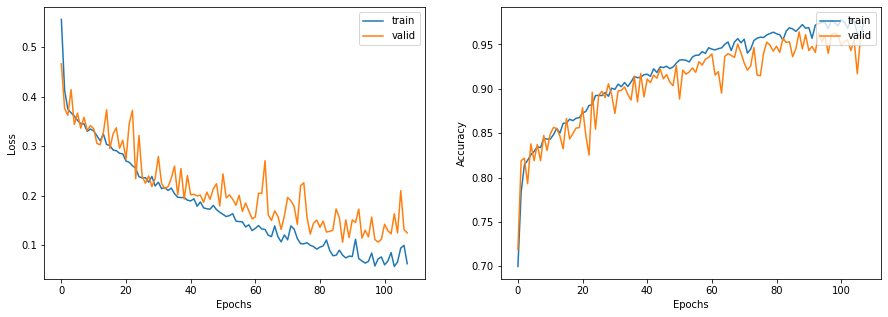

In [ ]:
import matplotlib.pyplot as plt
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

display_learning_curves(history)

In [ ]:
import tensorflow as tf
temp=tf.keras.models.load_model("./drive/MyDrive/LSTM_1d_exp1_exp5.h5")

In [ ]:
temp.evaluate(X_test_scaled, y_test[:,0], 1)

2851/2851 [==============================] - 10s 3ms/step - loss: 0.1059 - accuracy: 0.9642


[0.10585609078407288, 0.9642230868339539]

In [ ]:
temp.evaluate(X_test_scaled, y_test[:,0])

90/90 [==============================] - 1s 4ms/step - loss: 0.1059 - accuracy: 0.9642


[0.10585641115903854, 0.9642230868339539]

In [ ]:
y_pred = temp.predict(X_test_scaled)
y_pred= (y_pred>=0.5).astype(int)

In [ ]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [ ]:
confusion_matrix(y_test[:,0],y_pred)

array([[1960,   71],
       [  31,  789]])

In [ ]:
accuracy_score(y_test[:,0],y_pred)

0.9642230796211856

In [ ]:
f1_score(y_test[:,0],y_pred)

0.9392857142857143

In [ ]:
print(classification_report(y_test[:,0],y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2031
           1       0.92      0.96      0.94       820

    accuracy                           0.96      2851
   macro avg       0.95      0.96      0.96      2851
weighted avg       0.97      0.96      0.96      2851



In [ ]:
###Collect F-Score 10 times
import sklearn
from tqdm.notebook import tqdm
def calc_f1_score(X_train_scaled,X_test_scaled,y_train,y_test,earlystop):
  classifier = Sequential()
  classifier.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])))
  classifier.add(LSTM(units = 50))
  classifier.add(Dense(units = 1,activation='sigmoid'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  classifier.fit(X_train_scaled, y_train[:,0], epochs = 500, batch_size = 64,validation_data=(X_test_scaled,y_test[:,0]),callbacks=[earlystop])
  y_pred = classifier.predict(X_test_scaled)
  y_pred= (y_pred>=0.5).astype(int)
  return(sklearn.metrics.f1_score(y_test[:,0],y_pred))

f1_score_list=[]
for i in tqdm(range(10)):
  f1_score_list=f1_score_list+[calc_f1_score(X_train_scaled,X_test_scaled,y_train,y_test,earlystop)]
  print("Number of iterations",len(f1_score_list))
  print("F1-scores: ",f1_score_list)
  print("Average F1-Score",np.mean(f1_score_list))
  print("Std Dev F1-Score",np.std(f1_score_list))
  print("Error bar F1-Score",np.std(f1_score_list)/np.sqrt(len(f1_score_list)))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
334/334 [==============================] - 6s 10ms/step - loss: 0.5492 - accuracy: 0.7111 - val_loss: 0.5871 - val_accuracy: 0.7124
Epoch 2/500
334/334 [==============================] - 3s 8ms/step - loss: 0.5195 - accuracy: 0.7082 - val_loss: 0.4018 - val_accuracy: 0.7927
Epoch 3/500
334/334 [==============================] - 3s 8ms/step - loss: 0.4056 - accuracy: 0.7951 - val_loss: 0.3768 - val_accuracy: 0.8092
Epoch 4/500
334/334 [==============================] - 3s 8ms/step - loss: 0.3770 - accuracy: 0.8148 - val_loss: 0.3553 - val_accuracy: 0.8260
Epoch 5/500
334/334 [==============================] - 3s 8ms/step - loss: 0.3760 - accuracy: 0.8179 - val_loss: 0.3516 - val_accuracy: 0.8309
Epoch 6/500
334/334 [==============================] - 3s 8ms/step - loss: 0.3624 - accuracy: 0.8250 - val_loss: 0.3692 - val_accuracy: 0.8169
Epoch 7/500
334/334 [==============================] - 3s 8ms/step - loss: 0.3595 - accuracy: 0.8245 - val_loss: 0.3779 - val_accuracy: 0.807

In [ ]:
# Average F1-Score 0.8774318451407485
# Std Dev F1-Score 0.07971967750656386
# Error bar F1-Score 0.025209575525483453